# Data preprocessing and creating Word2Vec model

This implementation was made using the gensim library.
Here, I train two models using CBOW and skip-gram algorithms.
I also visualize the vectors of name of different characters for both models using TSNE.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct 21 22:13:03 2017

@author: shashwat
"""
# Imports

%matplotlib inline
import pandas as pd
import numpy as np
import nltk
import multiprocessing
from gensim.models import Word2Vec
import re
import os
from sklearn.manifold import TSNE
import seaborn

Using TensorFlow backend.


In [2]:
#%% Read Data

#all books merged into one text file
filename = 'Harry_Potter_books'
with open(filename) as f:
    corpus = f.read()
    
print('Total string length = ',len(corpus))


Total string length =  6530564


In [3]:
#%% Pre-Process Data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus)

def sentence_to_wordlist(raw):
    if raw.isdigit(): #for lines containing page no's
        return []
    clean = re.sub(r'[^A-Za-z0-9\s]',r'',raw)
    clean = re.sub(r'\n',r' ', clean)
    clean = " ".join([w.lower() for w in clean.split()])
    stops = set(nltk.corpus.stopwords.words("english"))
    clean = " ".join([w for w in clean.split() if w not in stops])
    #st = nltk.stem.PorterStemmer()
    #clean = " ".join([st.stem(w) for w in clean.split()])
    clean = " ".join([w for w in clean.split() if len(w)>1])
    words = clean.split()
    return words

sentences = []
for x in raw_sentences:
    if len(x)>1:
        sentences.append(sentence_to_wordlist(x))

print(raw_sentences[3])
print(sentence_to_wordlist(raw_sentences[3]))
    
token_count = sum([len(sentence) for sentence in sentences])

He was a big, beefy man with hardly any neck, al-
though he did have a very large mustache.
['big', 'beefy', 'man', 'hardly', 'neck', 'al', 'though', 'large', 'mustache']


In [4]:
#%% Create separate vocab for analysis and debugging
allwords = []
for sen in sentences:
    allwords += [w for w in sen]
    
from collections import Counter
cnt = Counter(allwords)

In [5]:
#%% Train CBOW Model
cores = multiprocessing.cpu_count()
embed_size = 300
hp_model_cbow = Word2Vec(sg=0, size = embed_size, min_count = 3, window = 10, sample = 1e-3, workers = cores)
hp_model_cbow.build_vocab(sentences)
print("Word2Vec Vocab length:", len(hp_model_cbow.wv.vocab))
print("Training!!")
hp_model_cbow.train(sentences, total_examples=hp_model_cbow.corpus_count, epochs=hp_model_cbow.iter)
hp_model_cbow.init_sims(replace=True)
print("Training finished!!")

Word2Vec Vocab length: 13958
Training!!
Training finished!!


In [6]:
#%% Train SG Model
hp_model_sg = Word2Vec(sg=1, size = embed_size, min_count = 3, window = 10, sample = 1e-3, workers = cores)
hp_model_sg.build_vocab(sentences)
print("Word2Vec Vocab length:", len(hp_model_sg.wv.vocab))
print("Training!!")
hp_model_sg.train(sentences, total_examples=hp_model_sg.corpus_count, epochs=hp_model_sg.iter)
hp_model_sg.init_sims(replace=True)
print("Training finished!!")

Word2Vec Vocab length: 13958
Training!!
Training finished!!


In [7]:
#%% save models
if not os.path.exists("trained_HP_model"):
    os.makedirs("trained_HP_model")
    
hp_model_cbow.save(os.path.join("trained_HP_model", "model_cbow.w2v"))
hp_model_sg.save(os.path.join("trained_HP_model", "model_sg.w2v"))


Plot for CBOW Model:

Plot for SG Model:


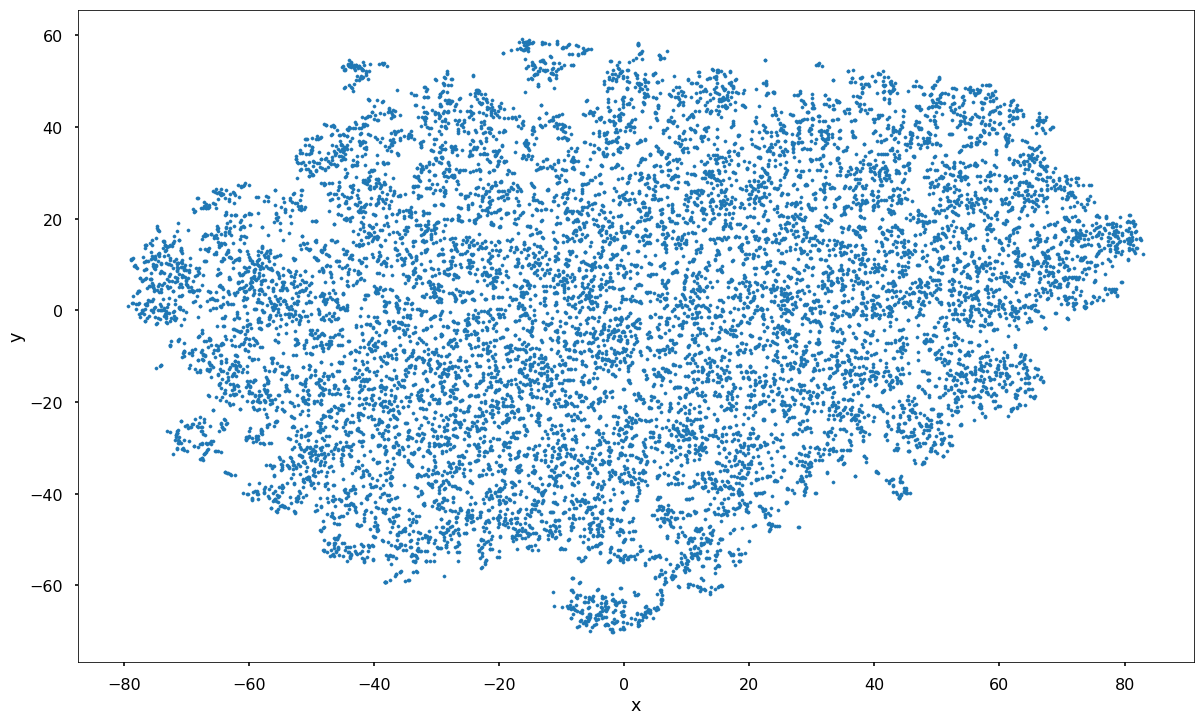

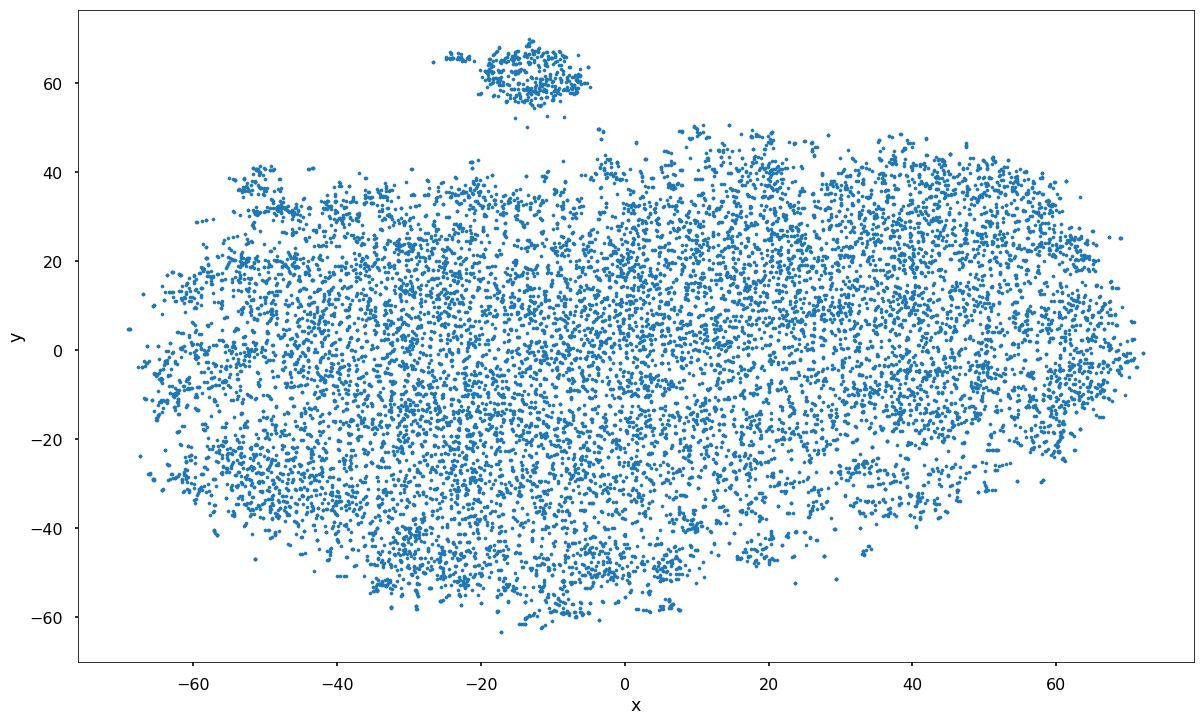

In [8]:
#%% Load Saved Model and tsne
hp_model_cbow = Word2Vec.load(os.path.join("trained_HP_model","model_cbow.w2v"))
hp_model_sg = Word2Vec.load(os.path.join("trained_HP_model","model_sg.w2v"))

tsne = TSNE(n_components=2, random_state=0)
word_vectors_cbow = hp_model_cbow.wv.syn0
word_vectors_2d_cbow = tsne.fit_transform(word_vectors_cbow)

word_vectors_sg = hp_model_sg.wv.syn0
word_vectors_2d_sg = tsne.fit_transform(word_vectors_sg)

#plot
points_cbow = pd.DataFrame( [ (word, coords[0], coords[1]) for word, coords in [(word, word_vectors_2d_cbow[hp_model_cbow.wv.vocab[word].index]) for word in hp_model_cbow.wv.vocab] ], columns=['word','x','y'])
points_sg = pd.DataFrame( [ (word, coords[0], coords[1]) for word, coords in [(word, word_vectors_2d_sg[hp_model_sg.wv.vocab[word].index]) for word in hp_model_sg.wv.vocab] ], columns=['word','x','y'])

print("Plot for CBOW Model:")
seaborn.set_context("poster")
points_cbow.plot.scatter("x", "y", s=10, figsize=(20, 12))

print("\nPlot for SG Model:")
seaborn.set_context("poster")
points_sg.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [9]:
#%% Character Name Analysis

characters = []
f = open('characters')
for line in f.readlines():
    characters.append(line[:-1].lower())
    
word_vectors_cbow = np.zeros(shape = (len(characters), embed_size))
word_vectors_sg = np.zeros(shape = (len(characters), embed_size))
for i,x in enumerate(characters):
    word_vectors_cbow[i] = hp_model_cbow[x]
    word_vectors_sg[i] = hp_model_sg[x]
    
    
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d_cbow = tsne.fit_transform(word_vectors_cbow)
word_vectors_2d_sg = tsne.fit_transform(word_vectors_sg)

#plot
points_cbow = pd.DataFrame( [ (word, coords[0], coords[1]) for word, coords in [(word, word_vectors_2d_cbow[characters.index(word)]) for word in characters] ], columns=['word','x','y'])
points_sg = pd.DataFrame( [ (word, coords[0], coords[1]) for word, coords in [(word, word_vectors_2d_sg[characters.index(word)]) for word in characters] ], columns=['word','x','y'])


First plot for CBOW and second for Skip Gram.


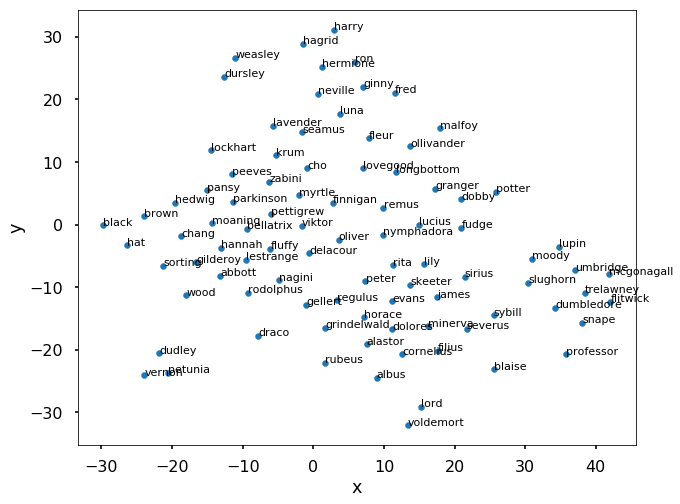

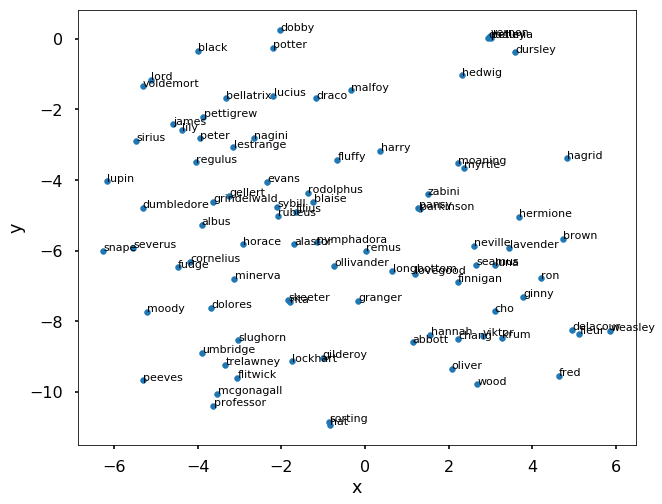

In [10]:
#%% Plot character scatter plots for both algorithms

def plot_region(x_bounds, y_bounds, points):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
     
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

print("First plot for CBOW and second for Skip Gram.")
plot_region(x_bounds=(-90, 90), y_bounds=(-80, 80), points=points_cbow)
plot_region(x_bounds=(-130, 130), y_bounds=(-125, 125), points=points_sg)

Note : The file Harry_Potter_books wasn't added to the repo for obvious reasons.